# better earthquake data 

conda install -c anaconda basemap  
conda install -c anaconda jupyter
conda install -c conda-forge basemap-data-hires

In [286]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd
import requests, pickle, time
from datetime import datetime
from mpl_toolkits.basemap import Basemap
import xmltodict

In [288]:
bounding_boxes = {
    'Hokkaido': {'minlat':41.241, 'maxlat':45.735, 'minlon':-221.601, 'maxlon':-210.897},
    'Honshu1':  {'minlat':34, 'maxlat':41.241, 'minlon':-222.772, 'maxlon':-217.5},
    'Honshu2':  {'minlat':33,  'maxlat':37, 'minlon':-226.683, 'maxlon':-222.772},
    'Honshu3':  {'minlat':32, 'maxlat':36, 'minlon':-228, 'maxlon':-226.683},
    'Kumamoto': {'minlat':31, 'maxlat':35, 'minlon':-231.466, 'maxlon':-228}
    }

xs, ys = {}, {}
for key in bounding_boxes:
    bb = bounding_boxes[key]
    xs[key] = [bb['minlon'], bb['maxlon'], bb['maxlon'], bb['minlon'], bb['minlon']]
    ys[key] = [bb['maxlat'], bb['maxlat'], bb['minlat'], bb['minlat'], bb['maxlat']]
all_xs = list(set(x for key in xs for x in xs[key]))
all_ys = list(set(y for key in ys for y in ys[key]))

In [291]:
def check_coords_in_a_bbox(latlong:tuple, bounding_boxes:dict=None):    
    if not bounding_boxes:
        bounding_boxes = {
            'Hokkaido': {'minlat':41.241, 'maxlat':45.735, 'minlon':-221.601, 'maxlon':-210.897},
            'Honshu1':  {'minlat':34, 'maxlat':41.241, 'minlon':-222.772, 'maxlon':-217.5},
            'Honshu2':  {'minlat':33,  'maxlat':37, 'minlon':-226.683, 'maxlon':-222.772},
            'Honshu3':  {'minlat':32, 'maxlat':36, 'minlon':-228, 'maxlon':-226.683},
            'Kumamoto': {'minlat':31, 'maxlat':35, 'minlon':-231.466, 'maxlon':-228}
            }
    bbs = bounding_boxes
    
    lat, long = latlong
    for b in b_bs:
        if all(b_bs[b]['minlat'] < lat,
               b_bs[b]['maxlat'] > lat,
               b_bs[b]['minlong'] < long,
               b_bs[b]['maxlong'] > long):
            continue
        else:
            return False
    return True

In [285]:
# perfect realtime data source (even last-month)  
    # https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php
    # api_uri = 'https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_month.csv'
    # df = pd.read_csv(api_uri)
    # df.set_index('id', inplace=True)
    # df.sort_values('time', ascending=False, inplace=True)
    # df.shape

In [211]:
df = pd.read_csv('../data/temp/quakes.csv', sep=';')

In [212]:
df2 = df[df.apply(
    lambda x:
        x.latitude < ur_lat
        and x.latitude > ll_lat
        and x.longitude < ur_lon
        and x.longitude > ll_lon
        ,
    axis='columns'
    )]

#### graph with boxes

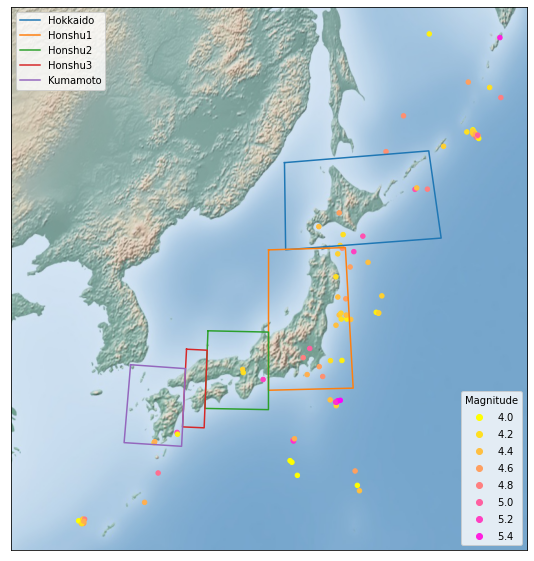

In [214]:
# graph with boxes
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

m = Basemap(llcrnrlon=ll_lon, llcrnrlat=ll_lat,
            urcrnrlon=ur_lon, urcrnrlat=ur_lat, 
            resolution='i', projection='cass', 
            lat_0=np.mean(all_ys), lon_0=np.mean(all_xs))
m.shadedrelief()

for box in xs:
    m.plot(x=xs[box], y=ys[box], latlon=True, label=box)

scale = 20
scatter_handle = m.scatter(
    x=df2.longitude, y=df2.latitude, 
    c=df2.mag, s=scale, cmap='spring_r',
    latlon=True)

legend1 = plt.legend(*scatter_handle.legend_elements(),
    loc='lower right', title="Magnitude")
ax.legend()
ax.add_artist(legend1)

plt.show()

## Historical Data

'https://service.iris.edu/fdsnws/event/1/query?starttime=2011-01-07T14:00:00&endtime=2011-02-07&minlatitude=15&maxlatitude=40&minlongitude=-170&maxlongitude=170&minmagnitude=5&includeallmagnitudes=true&orderby=magnitude'

In [267]:
def parse_quakeml_response(response):
    def event_to_row(event):
        lst = [
            event['origin']['@iris:contributorEventId'], 
            event['origin']['time']['value'],
            event['origin']['latitude']['value'],
            event['origin']['longitude']['value'],
            event['magnitude']['mag']['value'],
            event['origin']['depth']['value']
        ]
        return pd.Series(lst)

    event_list = xmltodict.parse(response.text)['q:quakeml']['eventParameters']['event']
    event_ser = pd.Series(event_list)
    df = pd.DataFrame(event_ser.apply(event_to_row))
    df.columns = ['id','datetime', 'lat', 'long', 'mag', 'depth_units?']
    df.set_index('id', inplace=True)
    float_cols = ['lat', 'long', 'mag', 'depth_units?']
    df[float_cols] = df[float_cols].astype(float)
    df['datetime'] = pd.to_datetime(df.datetime)
    return df

In [277]:
def plot_quakes(df):
    """
    expecting columns = ['lat', 'long', 'mag']
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    
    ll_lon, ur_lon, ll_lat, ur_lat = 122.5, 159.1, 25, 51.7
    lat_0=np.mean((ll_lat, ur_lat))
    lon_0=np.mean((ll_lon, ur_lon))
    m = Basemap(llcrnrlon=ll_lon, llcrnrlat=ll_lat,
                urcrnrlon=ur_lon, urcrnrlat=ur_lat, 
                resolution='i', projection='cass', 
                lat_0=lat_0, lon_0=lon_0)

    m.shadedrelief()

    scale = 20
    scatter_handle = m.scatter(
        x=df.long, y=df.lat, 
        c=df.mag.to_list(), s=scale, cmap='spring_r',
        latlon=True)

    legend1 = plt.legend(*scatter_handle.legend_elements(),
        loc='lower right', title="Magnitude")
    ax.add_artist(legend1)
    return fig

In [294]:
# get and save historical earthquake data 2015 through 2022
    # df = pd.DataFrame()
    # for year in range(2015, 2023):
    #     query_uri = (
    #         f'https://service.iris.edu/fdsnws/event/1/query'
    #         f'?starttime={year}-01-01'
    #         f'&endtime={year+1}-01-01'
    #         f'&minlatitude=31'
    #         f'&maxlatitude=45.735'
    #         f'&minlongitude=128.534'
    #         f'&maxlongitude=149.103'
    #         f'&minmag=4.5'
    #         )
    #     response = requests.get(query_uri)
    #     parsed = parse_quakeml_response(response)
    #     df = pd.concat((df, parsed), axis=0)
    #     time.sleep(5)
    # df.to_csv('../data/raw/quakes.csv', sep=';')

In [295]:
df = pd.read_csv('../data/raw/quakes.csv', sep=';')

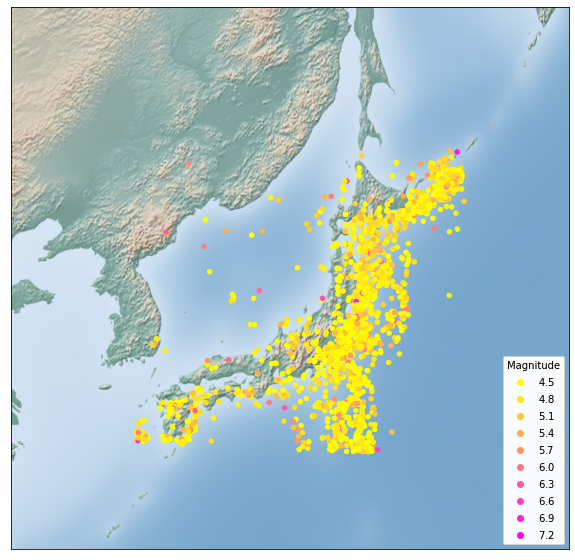

In [296]:
myfig = plot_quakes(df)

## UNUSED

https://github.com/usgs/libcomcat/blob/master/docs/api.md